In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.preprocessing import LabelEncoder

In [2]:
print("GPU is available:", tf.config.list_physical_devices('GPU'))

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# # CPU Optimizations 
# tf.config.experimental.set_virtual_device_configuration(
#     tf.config.experimental.list_physical_devices("CPU")[0],
#     [tf.config.experimental.VirtualDeviceConfiguration()],
# )

 # GPU Memory Limit Optimization
tf.config.set_logical_device_configuration(
     tf.config.list_physical_devices("GPU")[0],
     [tf.config.LogicalDeviceConfiguration(memory_limit=5899)],
)

In [4]:
train_df = pd.read_csv('twitter_training.csv')
validation_df = pd.read_csv('twitter_validation.csv')

In [5]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
validation_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [7]:
# Assign column names
train_df.columns = ['id', 'platform', 'label', 'text']  # Update names based on actual data
validation_df.columns = ['id', 'platform', 'label', 'text']

# Display the updated dataframes
print(train_df.head())
print(validation_df.head())

     id     platform     label  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  
     id   platform     label  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                                text  
0  BBC News - Amazon boss Jeff Bezos rejects clai...  
1  @Microsoft Why do I pay for WORD when it funct...  
2  CSGO matchmaking is so full of closet hacking,...  
3  Now the President is slapping Americans in the...

In [8]:
# Extract relevant columns
train_texts = train_df['text']
train_labels = train_df['label']

validation_texts = validation_df['text']
validation_labels = validation_df['label']


In [9]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text.strip()


In [10]:
train_texts = train_texts.fillna("").apply(clean_text)
validation_texts = validation_texts.fillna("").apply(clean_text)

In [11]:
# Assuming you have a clean_text function applied on train_text and validation_text
train_text_cleaned = [clean_text(text) for text in train_texts]
validation_text_cleaned = [clean_text(text) for text in validation_texts]

# Print cleaned texts
print("Cleaned Training Texts:")
for i, text in enumerate(train_text_cleaned[:5]):  # Print the first 5 for brevity
    print(f"{i + 1}: {text}")

print("\nCleaned Validation Texts:")
for i, text in enumerate(validation_text_cleaned[:5]):  # Print the first 5 for brevity
    print(f"{i + 1}: {text}")


Cleaned Training Texts:
1: i am coming to the borders and i will kill you all
2: im getting on borderlands and i will kill you all
3: im coming on borderlands and i will murder you all
4: im getting on borderlands  and i will murder you me all
5: im getting into borderlands and i can murder you all

Cleaned Validation Texts:
1: bbc news  amazon boss jeff bezos rejects claims company acted like a drug dealer bbccouknewsavbusine
2: why do i pay for word when it functions so poorly on my  chromebook
3: csgo matchmaking is so full of closet hacking its a truly awful game
4: now the president is slapping americans in the face that he really did commit an unlawful act after his  acquittal from discover on google vanityfaircomnewst
5: hi  ive had madeleine mccann in my cellar for the past  years and the little sneaky thing just escaped whilst i was loading up some fifa points she took my card and im having to use my paypal account but it isnt working can you help me resolve it please


In [12]:
# Encode labels as integers (label encoding)
label_map = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_labels = train_labels.map(label_map)
validation_labels = validation_labels.map(label_map)

In [13]:
# Step 3: Split Data (if necessary)
X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [14]:
# Parameters
max_vocab_size = 10000  # Maximum size of the vocabulary
max_sequence_length = 100  # Maximum length of each sequence
padding_type = 'post'  # Pad at the end of sequences
truncating_type = 'post'  # Truncate sequences at the end
oov_token = "<OOV>"  # Token for out-of-vocabulary words

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token=oov_token)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=truncating_type)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=truncating_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=truncating_type)

# Output a summary
print("Example Tokenized Training Sequence:", X_train_sequences[0])
print("Example Padded Training Sequence:", X_train_padded[0])
print("Tokenizer Word Index Size:", len(tokenizer.word_index))

Example Tokenized Training Sequence: [15, 2390, 1, 29, 19, 584, 28, 20, 9, 294, 33, 7, 250, 3970, 6, 7600, 7, 241, 3594, 5, 753, 3594]
Example Padded Training Sequence: [  15 2390    1   29   19  584   28   20    9  294   33    7  250 3970
    6 7600    7  241 3594    5  753 3594    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Tokenizer Word Index Size: 34973


In [15]:
print(np.unique(y_train))  # Check the unique values of labels

[0 1 2 3]


In [16]:
from keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
validation_labels = to_categorical(validation_labels, num_classes=4)


In [17]:
print(y_train.shape)  # Should be (number_of_samples, 4)
print(y_test.shape)   # Should be (number_of_samples, 4)
print(validation_labels.shape)  # Should be (number_of_samples, 4)


(59744, 4)
(14937, 4)
(999, 4)


In [18]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(validation_padded, validation_labels),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
1867/1867 [==============================] - 53s 25ms/step - loss: 0.9411 - accuracy: 0.6229 - val_loss: 0.4658 - val_accuracy: 0.8418
Epoch 2/20
1867/1867 [==============================] - 38s 20ms/step - loss: 0.5442 - accuracy: 0.8012 - val_loss: 0.2845 - val_accuracy: 0.9099
Epoch 3/20
1867/1867 [==============================] - 39s 21ms/step - loss: 0.3744 - accuracy: 0.8624 - val_loss: 0.2115 - val_accuracy: 0.9419
Epoch 4/20
1867/1867 [==============================] - 39s 21ms/step - loss: 0.2811 - accuracy: 0.8949 - val_loss: 0.1890 - val_accuracy: 0.9520
Epoch 5/20
1867/1867 [==============================] - 36s 20ms/step - loss: 0.2269 - accuracy: 0.9133 - val_loss: 0.1836 - val_accuracy: 0.9580
Epoch 6/20
1867/1867 [==============================] - 37s 20ms/step - loss: 0.1898 - accuracy: 0.9262 - val_loss: 0.2183 - val_accuracy: 0.9499
Epoch 7/20
1867/1867 [==============================] - 38s 20ms/step - loss: 0.1657 - accuracy: 0.9343 - val_loss: 0.1813 -

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

467/467 [==============================] - 5s 10ms/step - loss: 0.8705 - accuracy: 0.8593
Test Loss: 0.8704943656921387
Test Accuracy: 0.8592756390571594


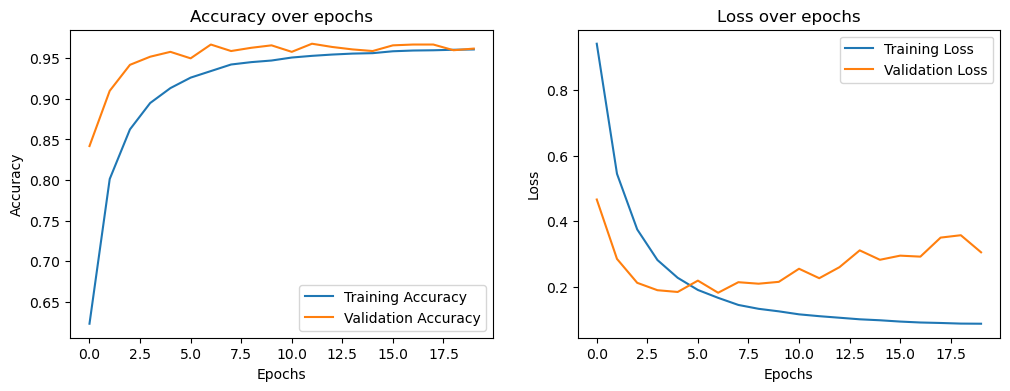

In [20]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# Predict on test set
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert y_test to class labels (for evaluation)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))

467/467 [==============================] - 5s 9ms/step
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4254
           1       0.82      0.87      0.84      3551
           2       0.88      0.89      0.89      4471
           3       0.86      0.81      0.83      2661

    accuracy                           0.86     14937
   macro avg       0.86      0.85      0.86     14937
weighted avg       0.86      0.86      0.86     14937



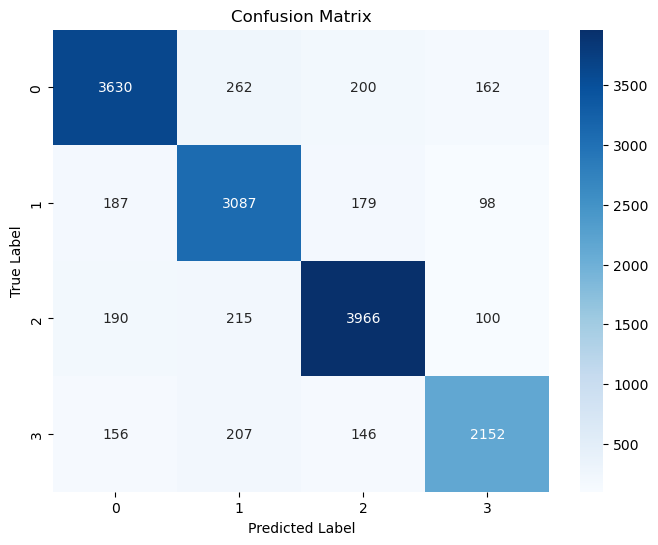

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


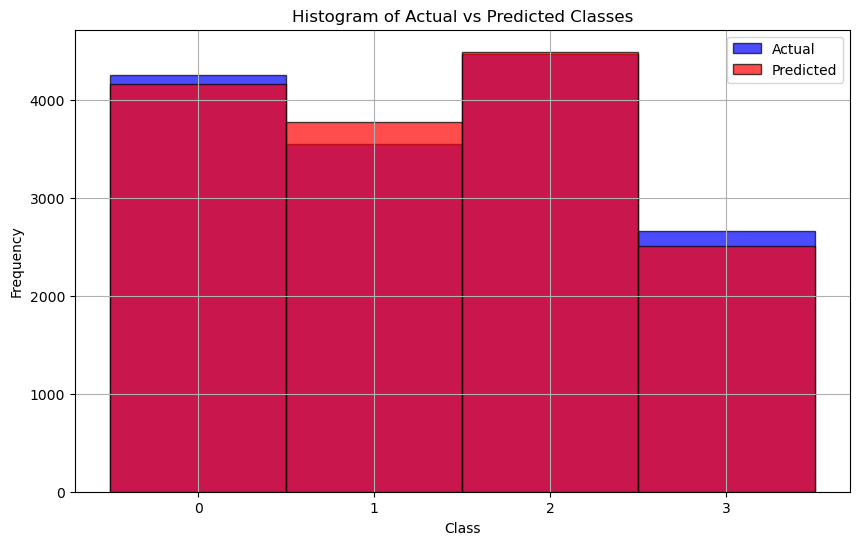

In [23]:
import matplotlib.pyplot as plt

# Plot histogram for actual vs predicted classes
plt.figure(figsize=(10, 6))

# Plotting the actual class distribution
plt.hist(y_test_classes, bins=np.arange(len(np.unique(y_test_classes)) + 1) - 0.5, alpha=0.7, label='Actual', color='blue', edgecolor='black')

# Plotting the predicted class distribution
plt.hist(y_pred_classes, bins=np.arange(len(np.unique(y_pred_classes)) + 1) - 0.5, alpha=0.7, label='Predicted', color='red', edgecolor='black')

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Actual vs Predicted Classes')
plt.legend()
plt.xticks(np.arange(len(np.unique(y_test_classes))))
plt.grid(True)
plt.show()
